## Credit Card Fraud detection using ML algorithms

### About dataset
The datasets contains transactions made by credit cards in a European city. The dataset presents transactions that occurred in two months containing 492 fraudulent transaction 284,807 transactions. 

### Actions
Predict if a transaction is fraudulent or not.

### My question: which ML algorithms should I use? An anomaly detection or supervised learning?
We will address it in the following


In [165]:
# Loading packages
import scipy.stats as stats
import numpy as np
import pandas as pd
print("pandas version:", pd.__version__)
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.ticker import LogFormatter 
import seaborn as sns

from collections import Counter

pandas version: 0.24.2


### Load Data from CSV FILE

In [166]:
# Loading Data
credit_card = pd.read_csv('C:/Users/adjanni/Desktop/Machine_Learning_Course/Projects/Credit_card_fraud/creditcard.csv')

# Summarising the shape of the dataset
print(f"The shape of the data is: ", credit_card.shape[0], "rows and ", credit_card.shape[1], "columns.")

The shape of the data is:  284807 rows and  31 columns.


### Data Preprocessing and visualization

In [167]:
# Access information
print(pd.DataFrame(credit_card.dtypes, columns=['dtypes']))

# Quick overview of the dataset
print(credit_card.sample(5))

# Check for missing values
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{credit_card.isnull().sum()}")

         dtypes
Time    float64
V1      float64
V2      float64
V3      float64
V4      float64
V5      float64
V6      float64
V7      float64
V8      float64
V9      float64
V10     float64
V11     float64
V12     float64
V13     float64
V14     float64
V15     float64
V16     float64
V17     float64
V18     float64
V19     float64
V20     float64
V21     float64
V22     float64
V23     float64
V24     float64
V25     float64
V26     float64
V27     float64
V28     float64
Amount  float64
Class     int64
            Time        V1        V2        V3        V4        V5        V6  \
183484  125821.0 -0.323334  1.057455 -0.048341 -0.607204  1.259821 -0.091761   
255448  157235.0 -0.349718  0.932619  0.142992 -0.657071  1.169784 -0.733369   
244749  152471.0 -1.614711 -2.406570  0.326194  0.665520  2.369268 -1.775367   
63919    50927.0 -2.477184  0.860613  1.441850  1.051019 -1.856621  2.078384   
11475    19899.0  1.338831 -0.547264  0.737389 -0.212383 -1.110039 -0.525744   

       

Most of the features are float. The Class, however, has only integer value. The features include Time, V1--V28, and Amount. The target is the Class column.

There is zero missing value in the dataset. It has been well processed!


### Explanation of the features

##### V1...V28: 
Each of this feature is the result of the PCA transformation of the original transaction. 

##### Amount
This is the transaction amount. It has not been transformed with PCA

##### Time
This is the number of seconds elapsed between transactions in the dataset. It corresponds to 02 months.

##### Class
Represents the response variable and takes value of 1 for fraudulent transactions, 0 otherwise

Total dataset Counter({0.0: 284315, 1.0: 492})
Class 0.0 Percentage 99.82725143693798
Class 1.0 Percentage 0.1727485630620034


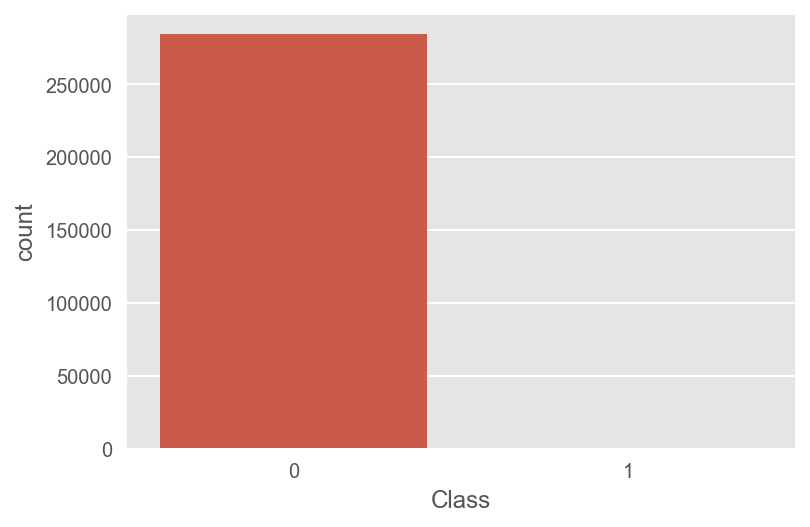

In [168]:
### Summarise the class distribution
target = credit_card.values[:, -1]
counter = Counter(target)
print("Total dataset", counter)

for k, v in counter.items():
    perc = (v / float(len(target))) * 100
    print('Class', k, 'Percentage', perc)
    #print('Class = %d, Count = %d, Percentage = %.3f%%' % (k, v, perc))
    #sns.barplot( y = perc)

sns.countplot("Class",data=credit_card)

### Observation
The dataset has two classes:
    1. Normal transaction (y = 0) -- negative
    2. Fraudelent transaction (y = 1) -- positive

With about 99.82% of transactions marked as negative and about 0.1727% marked as positive, this inferes that the data are severely skewed -The learning algorithm will more likely predict y = 0. We should be extremely caution on the learning algorithm to use and the type of evaluation metric to use. 

## Shall we use an Unsurpervised Anomaly Detection or Supervised Learning??  
We observe the following:

    (.) Very small number of positive: 492. It corresponds to about 0.17% of the dataset
    (.) Large number of negative: 284315. It corresponds to 99.82% of the dataset

Based on these two initial observations and the labelled output, we suggest Supervised Anomaly Detection algorithms will provide an estimation with high probability. We will compare the performance of:
    
    (.) Collaborative filtering algorithm: K-nearest neigbor (KNN) 
    (.) Support Vector Machine (SVM)
    (.) Neural Network (NN)

Also, given the imbalance nature of the dataset, a good evaluation metric that will be computed are:

    (.) True positive (TP), false positive (FP), false negative (FN), true negative (TN)
    (.) Precision = TP/(TP + FP) - measure the quality of the data returned as positive
    (.) Recall = TP/(TP + FN) - how many true positives were detected as positive
    (.) F1-score
In the following, the quantification of the TP, FP, FN, and TN are represented by the 'Confusion Matrix'.

    
### Let s investigate the correlation between input variables

Text(0.5, 1.0, 'Heatmap of Correlation between input variables')

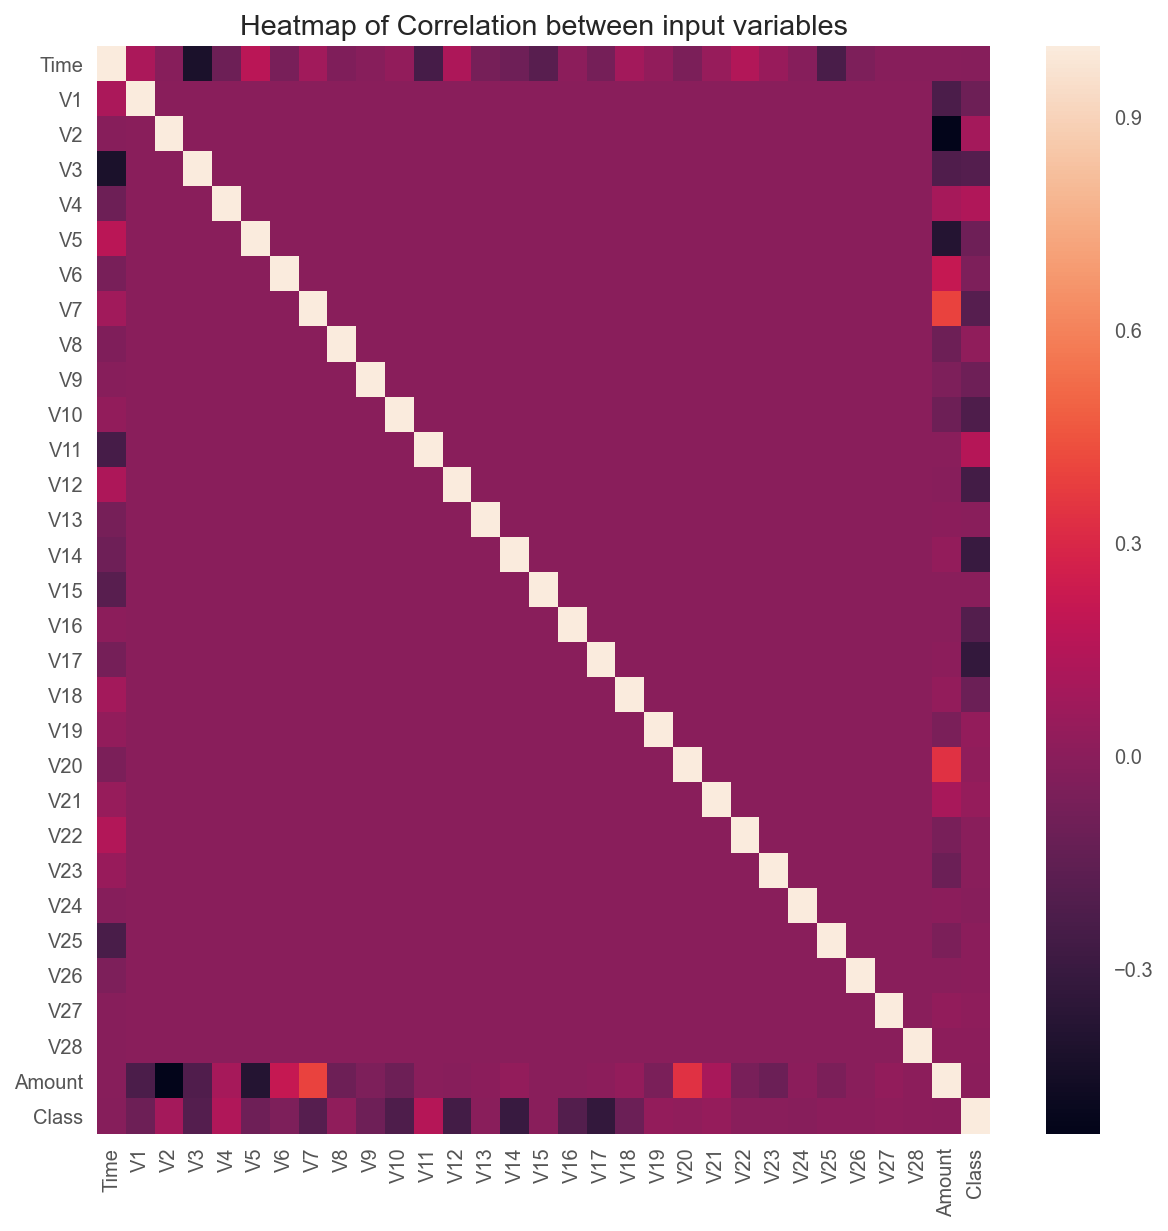

In [169]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(credit_card.corr(), ax = ax)
plt.title('Heatmap of Correlation between input variables')

We clearly see that there is no correlation between the input variables! However, looking at the correlation between 'Amount' and the client transaction V1--V28:

        (x)  The correlation coefficient between Amount-V7, Amount-V20 seem to be about 0.5. We should keep this in mind!

The correlation between Class and V1--V18 vary between -0.6 (V17 e.g) and 0.5 (V11). 

### Classes and target Extraction

In [170]:
# Extract negative and positive data
negative = credit_card[credit_card['Class'] == 0]
positive = credit_card[credit_card['Class'] == 1]

# Extract the target
target = credit_card.values[:, -1]

# Drop the last column
credit_card_d = credit_card.drop("Class", axis = 1)
pos = positive.drop("Class", axis = 1)
neg = negative.drop("Class", axis = 1)
print('Normal', neg.shape, 'Fraudulent', pos.shape)

Normal (284315, 30) Fraudulent (492, 30)


# Gaussian distribution of the features

Visualise the normal and fraudulent transaction on top of each other:
    
    (...) Normal transaction (blue)
    (...) Fraudulent transaction (red)

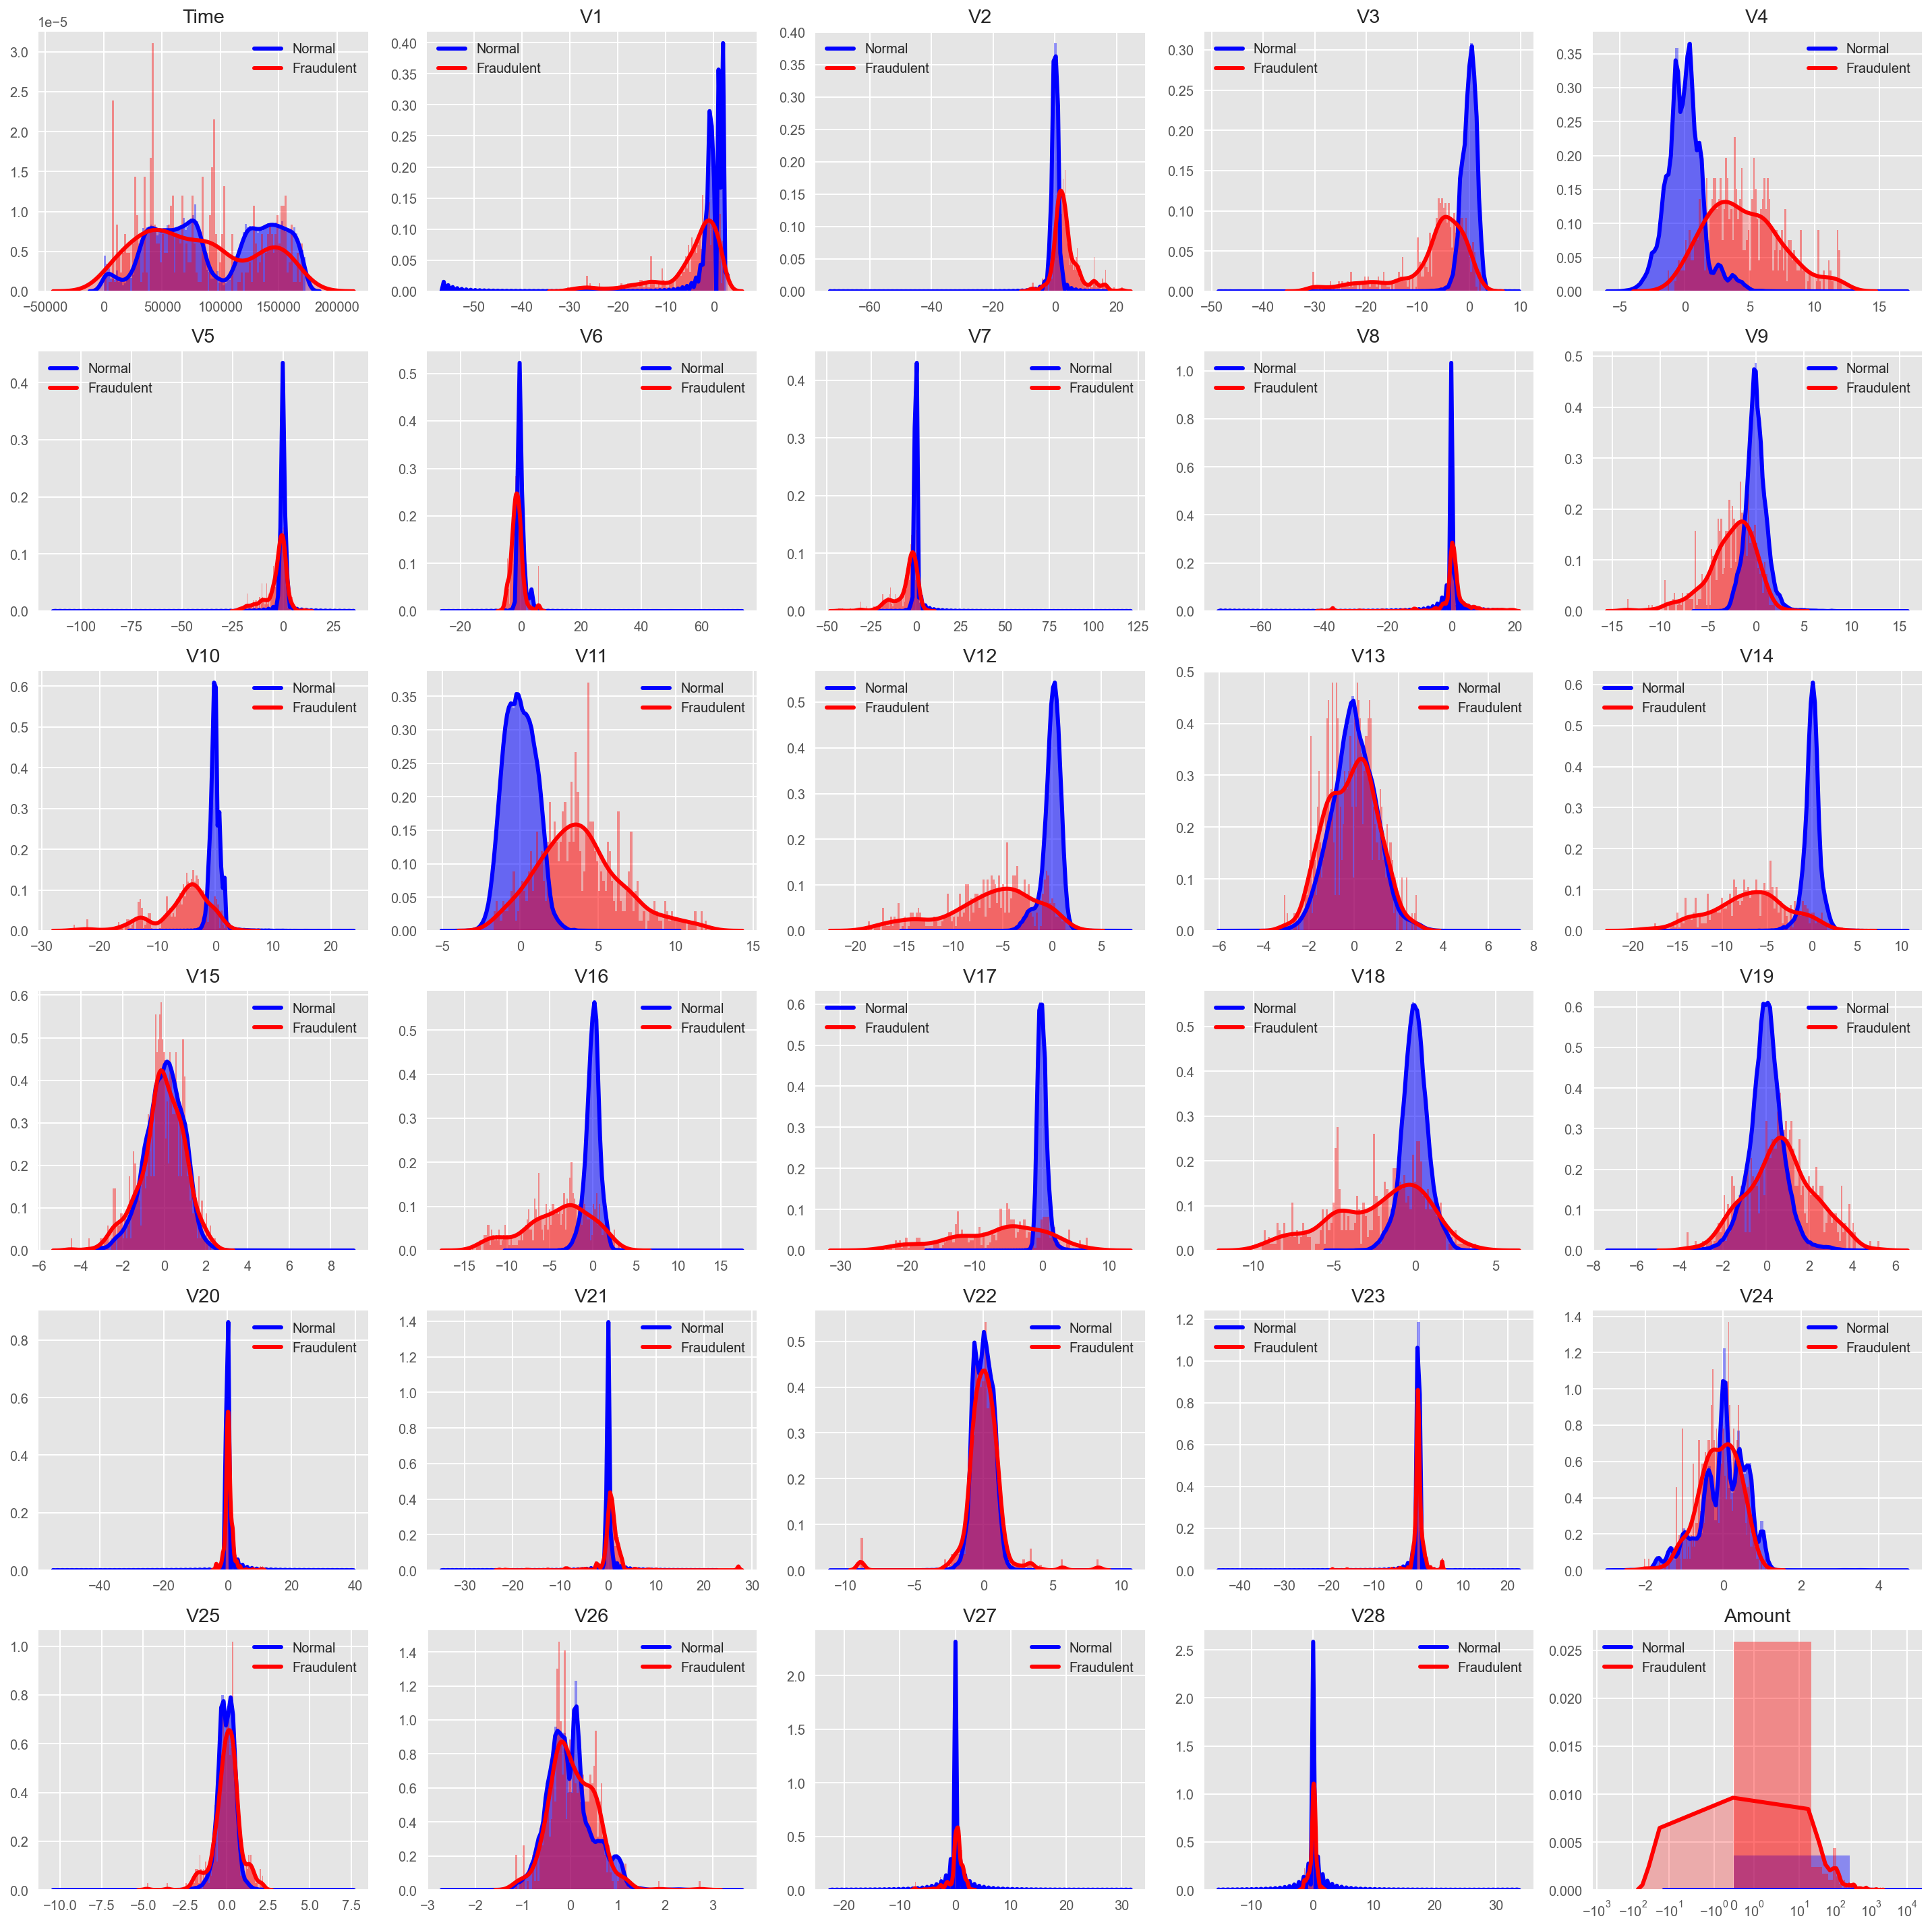

In [171]:
# We are going to plot 30 histograms, one for each variable
from matplotlib.ticker import LogFormatter

variables = list(neg.columns)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

for i, v in enumerate(variables):    
    # Set up the subplot
    ax = plt.subplot(6, 5, i + 1)
    if v in ['Amount']:
        sns.distplot(neg[v].values, kde_kws = {'shade': True, 'linewidth': 3, "label": "Normal"}, bins = 100, kde = True, ax = ax, color="b");
        sns.distplot(pos[v].values, kde_kws = {'shade': True, 'linewidth': 3, "label": "Fraudulent"}, bins = 100, kde = True, ax = ax, color="r");
        ax.set_xscale('symlog')
        # Formating log tick axis
        formatter = LogFormatter(labelOnlyBase = False, minor_thresholds = (1, 0.4)) 
        ax.get_xaxis().set_minor_formatter(formatter) 
        
        #ax.set_yscale('log')
        plt.title(v)
    else:
        sns.distplot(neg[v].values, kde_kws = {'shade': True, 'linewidth': 3, "label": "Normal"}, bins = 100, kde = True, ax = ax, color="b");
        sns.distplot(pos[v].values, kde_kws = {'shade': True, 'linewidth': 3, "label": "Fraudulent"}, bins = 100, kde = True, ax = ax, color="r");
        plt.title(v)
            
fig.tight_layout()
plt.show()

#log scale of x a scale log 10 + annotation logtick

#fig, our_axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 20)) # See: Comment (1)
#v_axes = [ax for ax_rows in our_axes for ax in ax_rows]

#for i, v in enumerate(variables):
   # print("neg[i]", i, "v", v)
 #   c_axes = v_axes[i]
    #print('current_axes', c_axes)
    #current_var_data = neg[v]
    #c_axes.hist( current_var_data,alpha=0.5, bins = 100,color = ['blue'], density=True)
    #c_axes2 = v_axes[i].twinx()
    #c_axes.set_ylim(0, 2)
    #c_axes2.hist(c_axes.get_xticks(),pos[v].values)
    #c_axes.hist(pos[v].values, alpha=0.5, bins = 100,color = ['red'], density=True) 
    #c_axes.set_title(variables[i]) # Give our Axes a unique title
    #c_axes.set_yscale('log')
    #c_axes.grid(False)     
#fig.tight_layout()
#plt.show() # Fin! 

## Observation

Most of the PCA data are gaussian with the mean centered around 0. This means that the variables were standardised as part of the PCA transformation. Let's look closely at some inputs.

    (1) Time - The data were collected over a period of two months. The normal transaction (blue) shows two considerable throughs that could be associated to the end of the previous/ and begining/ of a new month. After that dip, the density increases, hit a plateau, and decreases as the month is coming to an end. The Fraudulent transaction, however, has almost a constant density throughout the two months. The spendings are made at an equal level regardless of the period of the month. Can this feature help to differenciate the fraud from the real transaction?

Concerning the histogram plots of the features V1 - V28, 02 groups can be identified. For example:

    (S1) The one where the there is a clear difference between the normal and fraudulent transaction. For example
    
        (1) the subgroup (V4, V11, V19) and (V3, V10, V14): The normal transaction density is center around 0 and the fraudulent either has negative or positive value. If we take V4 for example, the normal transaction varies between -5 and 5 whereas the fraudulent transactin has a mean equal to about 3 and varies between -5 and 15. This means that for V4, a transaction that falls between 5 and 15 will be considered as fradulent.
    
        (2) The subgroup (V18. V24, V25) in which the fraud and normal transactions seem to overlap. Unlike the previous subgroup, it is not easy to differenciate the two kinds of transaction. 

## Conclusion
We observe that there are many types/groups of positive data. This may suggest that future anomalies will more likely look different to the current ones. Hence, very difficult to predict. This obvervation contributes to demonstrate that anomaly detection algorithm instead of a superfised learning algorithm MUST be used!

Let s have access to a quick statiscal description of the data.

In [172]:
# Estimate the parameters of the gaussians
#def gaus_parameters(df):
#    mu = df.mean(axis = 0)
#    sigma2 = np.var(df)
    #var = (1/df.shape[0]) * (df - mu
    
#    return mu, sigma2

#mu_pos, sigma2_pos = gaus_parameters(pos)
#mu_neg, sigma2_neg = gaus_parameters(neg)

#features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
# 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
# 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
# 'V26', 'V27', 'V28']
#fig,ax = plt.subplots()
#for i, v in enumerate(features):
    #print(i)
    #print(mu_pos.values[i])
    #ax.plot(mu_pos.values[i], sigma2_pos.values[i], marker='o', markerfacecolor='red', markersize=12)

#pyplot.show()

## Statiscal investigation of the features

In [173]:
# Investigate statiscal analys,is of the negative and positive data
display(neg['Amount'].describe())
display(pos['Amount'].describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

##### Observation
We can observe that the mean of fraudulent transaction is about 1.5 times higher that the normal transaction. Also, looking at the normal transaction, the mean suggests that the amount of money retrieved by customers is small. However, the maximum amount of money someone retrieved is 25691.16. May be this customer bought a car with his credit card! The direct consequence is that the dataset becomes skew.


# Working with large and skewed datasets 

    1. Take 5% of the datasets (to find the k-value) and divide them into Features and Target variable. I will work on this subset througout the hyperparameter tuning. Once the best model is identified, we can go ahead and use it in the entire dataset for training and subsequent model deployment.
    
    2. I will use 5-fold cross-validation with 1 repetition
    
    

## Extracting Features and Target variable

In [174]:
#  Features
X = credit_card_d;

# Choose 5% of the data for hyperparameters turming
fracs = 0.05

# Taking 5% of the datasets for testing purposes
X = credit_card_d.sample(frac = fracs, random_state = 1)

# Target (expected class)
y = credit_card["Class"];
y = credit_card["Class"].sample(frac = fracs, random_state = 1)

# Extract the numpy array for processing purposes
X_data = X.values;
y_data = y.values;
print(X.shape, y.shape)


(14240, 30) (14240,)


### Divide the dataset into Training and Test set
To evaluate my ML algorithm, the dataset are split into 02 parts:

    --  Training set: 70%
    --  Test set: 30% 

Before performing this division, we randomly sorted the dataset

In [175]:
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn import metrics

In [176]:
train_ratio = 0.7
#validation_ratio = 0.2
test_ratio = 0.3

# To keep the same result with every run
np.random.seed(0)


# split 70% and 30%
#Because the class is highly unbalanced and to ensure that the proportion of y is present in each split, we use
# stratify=y. Hence, the train and test sets will have an equal distribution.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=1 - train_ratio, random_state = 2, stratify = y_data);

print("Features-Training set shape", X_train.shape[0], "--Features-Test set shape ", X_test.shape[0], "--Y test set shape set ", y_test.shape[0])

Features-Training set shape 9967 --Features-Test set shape  4273 --Y test set shape set  4273


class value:  0 row index:  [   0    1    2 ... 9964 9965 9966]
class value:  1 row index:  [ 844 1490 1625 2130 2369 2976 3801 4178 4199 4663 5667 7567 8707 9264]


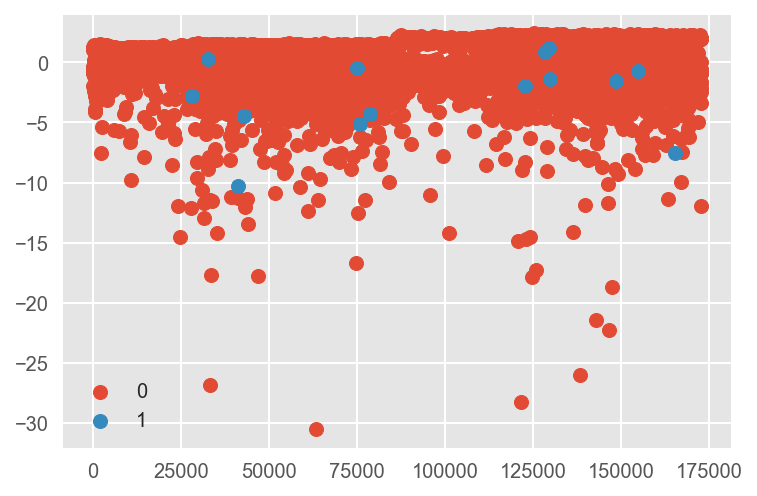

In [177]:
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_blobs

def plot_dataset(X, y):
    # Create scatter plot for samples from each class
    n_classes = len(set(y))
    for class_value in range(n_classes):
        # get row indexes for samples with this class
        row_idx = where(y == class_value)[0]
        print("class value: ", class_value, "row index: ", row_idx)
        # Create scatter of these samples
        pyplot.scatter(X[row_idx, 0], X[row_idx, 1], label=str(class_value))
    # Show a legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
plot_dataset(X_train, y_train)        

# Features Scaling

Before making an actual predictions, it s always a good practice to scale the features so that all of them are on a similar scale. We remove the mean value of each feature and divide non-constant features by their standard deviationWe could use the following:

    (X - mu)/sigma2, mu == mean of the feature, sigma2 == the std of the feature
    
We will use instead import StandardScaler from Sklearn.preprocesing. The new features should range between about -1 and 1.


In [178]:
from sklearn import preprocessing

print("Before scaling", X_train[1])
# Compute the mean and standard deviation on a training set [-1 1]
scaler = preprocessing.StandardScaler().fit(X_train)

# Apply the feature scaling on x_train
X_train = scaler.transform(X_train)

# Reapply the same transformation on the test set
X_test = scaler.transform(X_test)
print("After scaling", X_train[1])

Before scaling [ 1.31453000e+05  2.03604082e+00 -5.22289369e-01 -1.61012472e+00
 -1.98448202e+00 -2.97014900e-01 -1.84857915e+00  3.94214683e-01
 -5.60858666e-01  1.78148954e+00 -1.28923978e+00 -2.26130385e-01
  1.59207351e+00  1.17448878e+00  3.14759501e-01  1.17838380e+00
 -1.14988029e+00 -2.00337860e-01 -5.12872055e-01  1.18443401e+00
 -4.06630584e-02 -1.76382598e-01 -3.41045446e-01  1.74314184e-01
 -1.11040857e-02  5.80648924e-02 -1.11228443e+00  2.64957348e-02
 -3.78036808e-02  5.68600000e+01]
After scaling [ 0.77279731  1.02805506 -0.28971389 -1.09421372 -1.41775193 -0.21312342
 -1.38046882  0.32852177 -0.4093833   1.59049723 -1.20275644 -0.22152006
  1.61653444  1.17491419  0.31650187  1.28855587 -1.30552268 -0.23834837
 -0.61167211  1.43358997 -0.05070519 -0.22251502 -0.47089313  0.25555027
 -0.01795762  0.12636308 -2.30277742  0.07579324 -0.09592155 -0.14122013]


# 1. Supervised Anomaly Detection: K-NN algorithm


A key parameter in K-NN is the number K of nearest points to take. To help to find this values, we plot the graph of the K values between 1 and 50. The first step is to split the datasets into training and test set.



### Trial 1: K-NN with x_train & x_test

We will use the training set to build an accurate model. Then use the test set to report the accuracy of the model.


K-value |  1
f1_score [0.99863504 0.99929792 0.99906389 0.99906389 0.99953194 0.99953194
 0.99953194 0.99953194 0.99953194 0.99929792 0.99882986 0.99859583
 0.99859583 0.99859583 0.99859583] std f1_1 
 [5.22995399e-004 6.36598737e-314 1.06099790e-313 1.48539705e-313
 1.90979621e-313 2.33419537e-313 2.75859453e-313 3.18299369e-313
 3.60739285e-313 4.03179200e-313 4.45619116e-313 4.88059032e-313
 5.30498948e-313 5.72938864e-313 6.15378780e-313]

Time to completion:  1.61 Second 

K-value |  3
f1_score [0.99863504 0.99926605 0.99906389 0.99906389 0.99953194 0.99953194
 0.99953194 0.99953194 0.99953194 0.99929792 0.99882986 0.99859583
 0.99859583 0.99859583 0.99859583] std f1_1 
 [5.22995399e-004 4.05205401e-004 1.06099790e-313 1.48539705e-313
 1.90979621e-313 2.33419537e-313 2.75859453e-313 3.18299369e-313
 3.60739285e-313 4.03179200e-313 4.45619116e-313 4.88059032e-313
 5.30498948e-313 5.72938864e-313 6.15378780e-313]

Time to completion:  3.01 Second 

K-value |  5
f1_score [0.99863504 

C:\Users\adjanni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score [0.99863504 0.99926605 0.99897039 0.99897039 0.99948519 0.99948519
 0.99948519 0.99948519 0.99948519 0.99918103 0.9984123  0.99789424
 0.99859583 0.99859583 0.99859583] std f1_1 
 [5.22995399e-004 4.05205401e-004 4.67836104e-004 4.67836104e-004
 3.30887563e-004 3.30887563e-004 3.30887563e-004 3.30887563e-004
 3.30887563e-004 4.05205401e-004 5.22995399e-004 5.72845634e-004
 5.30498948e-313 5.72938864e-313 6.15378780e-313]

Time to completion:  4.09 Second 

K-value |  25


C:\Users\adjanni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score [0.99863504 0.99926605 0.99897039 0.99897039 0.99948519 0.99948519
 0.99948519 0.99948519 0.99948519 0.99918103 0.9984123  0.99789424
 0.99789424 0.99859583 0.99859583] std f1_1 
 [5.22995399e-004 4.05205401e-004 4.67836104e-004 4.67836104e-004
 3.30887563e-004 3.30887563e-004 3.30887563e-004 3.30887563e-004
 3.30887563e-004 4.05205401e-004 5.22995399e-004 5.72845634e-004
 5.72845634e-004 5.72938864e-313 6.15378780e-313]

Time to completion:  4.59 Second 

K-value |  27


C:\Users\adjanni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score [0.99863504 0.99926605 0.99897039 0.99897039 0.99948519 0.99948519
 0.99948519 0.99948519 0.99948519 0.99918103 0.9984123  0.99789424
 0.99789424 0.99789424 0.99859583] std f1_1 
 [5.22995399e-004 4.05205401e-004 4.67836104e-004 4.67836104e-004
 3.30887563e-004 3.30887563e-004 3.30887563e-004 3.30887563e-004
 3.30887563e-004 4.05205401e-004 5.22995399e-004 5.72845634e-004
 5.72845634e-004 5.72845634e-004 6.15378780e-313]

Time to completion:  4.79 Second 

K-value |  29


C:\Users\adjanni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score [0.99863504 0.99926605 0.99897039 0.99897039 0.99948519 0.99948519
 0.99948519 0.99948519 0.99948519 0.99918103 0.9984123  0.99789424
 0.99789424 0.99789424 0.99789424] std f1_1 
 [0.000523   0.00040521 0.00046784 0.00046784 0.00033089 0.00033089
 0.00033089 0.00033089 0.00033089 0.00040521 0.000523   0.00057285
 0.00057285 0.00057285 0.00057285]

Time to completion:  4.47 Second 



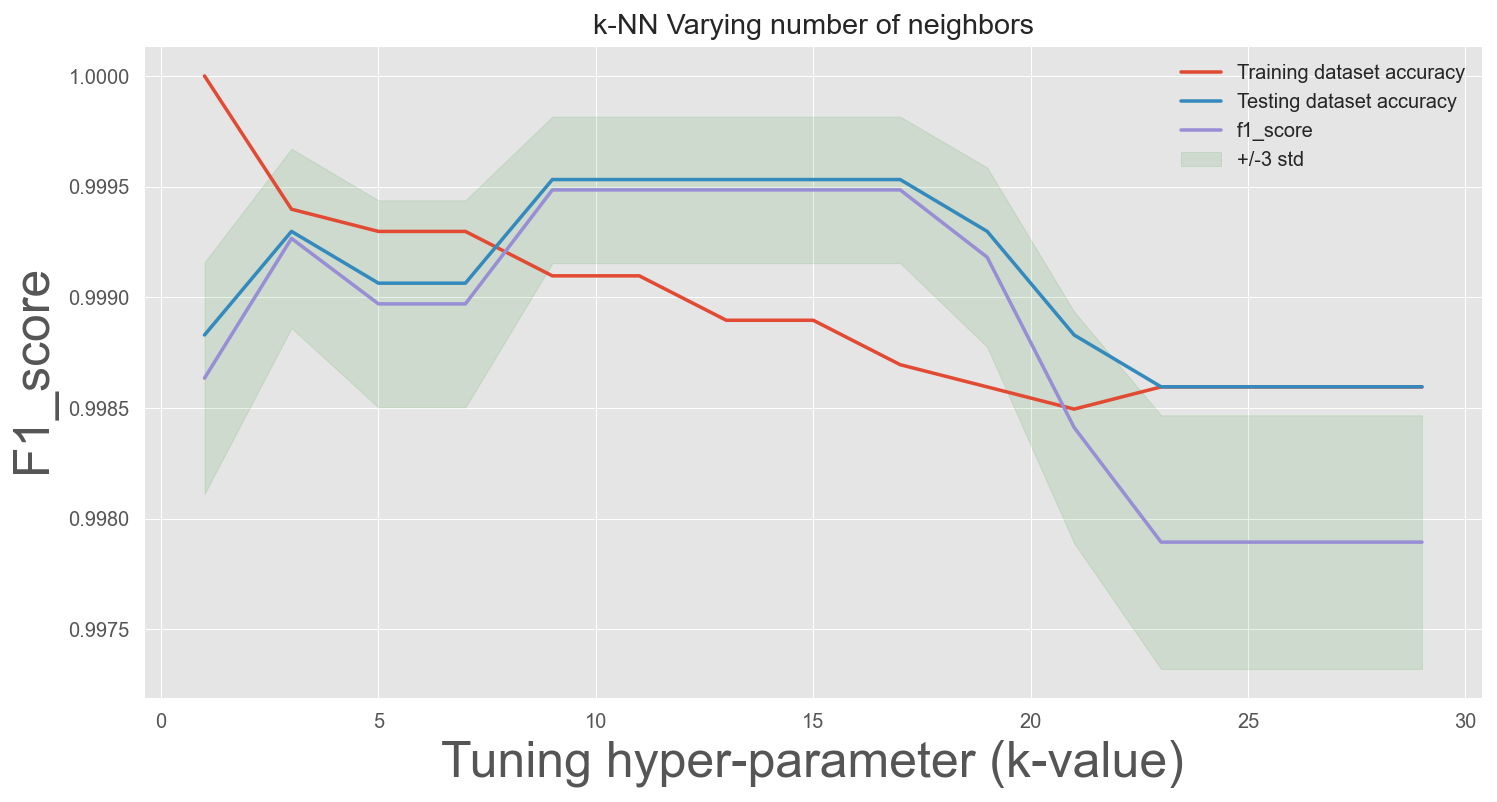

In [179]:
import multiprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time

# Getting the nber of CPUs in the pc
num_cpus = multiprocessing.cpu_count()

num_neighbors = 30
myList = list(range(0,num_neighbors))
neighbors = list(filter(lambda x: x%2!=0, myList)) 


train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
f1 = np.empty(len(neighbors))
std_f1 = np.empty(len(neighbors))

# Use iteration to calculate different k in models, then return the average err
error = []
    
for i, k in enumerate(neighbors):
    print("K-value | ", k )
    # Start time
    st_time = time.perf_counter()    
    
    # Build KNN model and choose n_neighbors = k - n_jobs specify the number of cores that need to be used in the process!
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = num_cpus -1)
    #training_score = cross_val_score(knn, X_train, y_train, cv=5)
    #cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    #x=plot_learning_curve(knn, X_train, y_train,i, (0.87, 1.01), cv=cv, n_jobs=4)
    #x.show()
    
    # Fit the model, knn, to tht Training set. I train my model with different values of "k" and capture its accuracy on my test data.
    knn.fit(X_train, y_train)
    #print("Model parameters ", knn)
    
    # Compute training and test accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    
    # Evaluation of the model predictions against the test dataset
    # a-/ Get the predict value on test set
    y_pred = knn.predict(X_test)
    
    y_expect = y_test
    x_expect = X_test
    
    f1[i] = f1_score(y_expect, y_pred, average='weighted')
    std_f1[i] = np.std(y_pred == y_expect)/np.sqrt(y_pred.shape[0])
    
    print("f1_score", f1, "std f1_1 \n", std_f1)
    
    # Adds error rate of model woth various k-value (whenever y_pred is not matching the expected)
    error.append(np.mean(y_pred != y_expect))
    
    # Print error
    end_t = time.perf_counter()
   
    print(f'\nTime to completion: {end_t - st_time: .2f} Second \n')

# Generate plot
plt.figure(figsize=(12, 6))
plt.plot(neighbors, train_accuracy, label = "Training dataset accuracy")
plt.plot(neighbors, test_accuracy, label = "Testing dataset accuracy")
plt.plot(neighbors, f1, label = "f1_score")
plt.fill_between(neighbors, f1 - 1 * std_f1, f1 + 1 * std_f1, alpha=0.10, color='green', label = "+/-3 std")

plt.legend()
plt.title('k-NN Varying number of neighbors')
plt.xlabel(' Tuning hyper-parameter (k-value) ', fontsize=25)
plt.ylabel(' F1_score ', fontsize=25)
plt.grid(linestyle='-', linewidth=0.5)
plt.show()

From the above plot, for k = 1, the prediction on the training set is perfect. However, as k increases, the training accuracy drops, indicating that using a single nearest neighbors leads to a model that is too complex!

However, looking at the test set, the maximum accuracy is obtained at k = 9. Above this value, it's constant until k = 17 and decreases afterwards until 23.  

0.9988292093554654

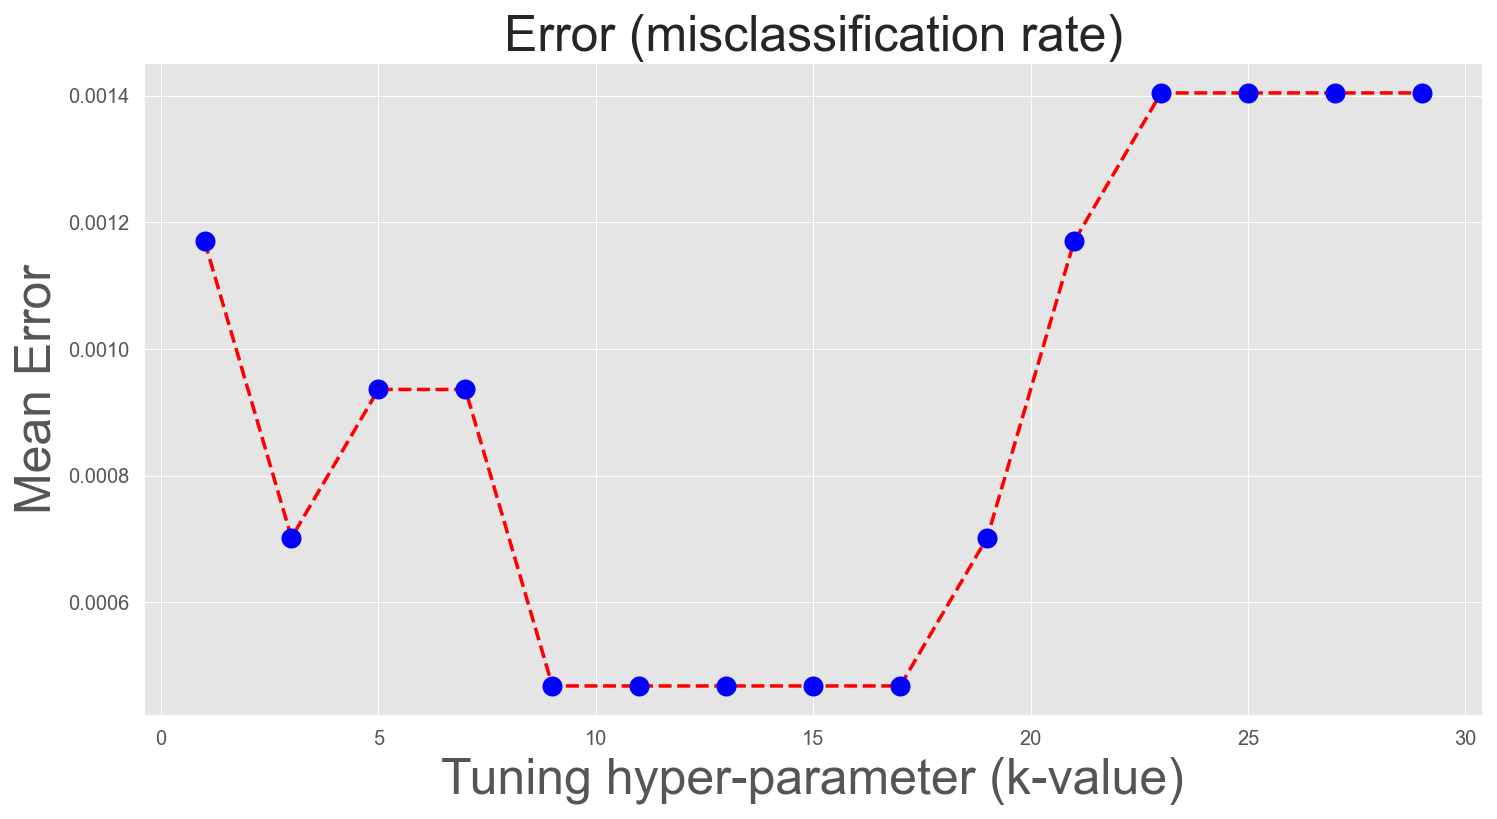

In [227]:
plt.figure(figsize=(12, 6))
plt.plot(neighbors, error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title("Error (misclassification rate)", fontsize=25)
plt.xlabel(" Tuning hyper-parameter (k-value) ", fontsize=25)
plt.ylabel("Mean Error", fontsize=25)
plt.grid(linestyle='-', linewidth=0.5)

In [181]:
Optimal_k = neighbors[error.index(min(error))]
print("The optimal k is: ", Optimal_k)


The optimal k is:  9


## How accurately my model will predict the class label of a future unseen dataset?

I used the test data to determine the right value of k and the treain set to find the nearest neighbors. The best accuracy (99.99%) is obtained for k = 3 on the test set which I also used to determine the optimal value of k. 

#### However, can I say, with confidence, that I can predict with 99.9% accuracy the future unseen label? The answer is obviously NO because I have no more data with me as I have split into 70:30 ratio. To address this issue, I neeed the cross validation set. 



## Find the optimal parameters by using GridSearch
GridSearch can find the best parameters for a classifier. In this case, I will use it for the KNN-algorithms and compared it with the value obtained with the previous methods.

##### Explanation k-fold fmethod
In k-fold cross-validation, the training set is randomly partioned into k equal size subsamples: $k-1$ training set and $1$ is used at every run as the validation set. 

For example, in the following, for 5-folds, I train on 4 of them and leave one out as validation set. The algorithm performs it 5 times (leave out every partition exactly once) and average the validation error across runs.
    
    (.) Model 1: the first Fold 1 is the validation set, and the 04 equal size fold are Training sets
    (.) Model 2: The second Fold 2 becomes the validation set and the first and the three others become the training set
    (.) ...
    (.) Model 5: The four first folds are the training set and the last one, the validation set.
    
In the following, we conduct a stratified 5-fold (n_splits = 5) cross-validation with 1 repetitions (n_repeats = 1) using the $RepeatedStratifiedKFold$ function. Since the target labels are very skewed with fewer fraudulent transaction labels than normal one, stratification ensures that the proportion of the two labels in both train and test sets are the same as the proportion in the full dataset in each cross-validation repetition.

In [182]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Control how the knn neigbors are weighted while making a prediction.
# uniform = all points are weighted equally (default)
# distance = weighted close neigbors more heavily than far one
weight_options = ['uniform','distance']

cv_method = RepeatedStratifiedKFold(n_splits = 5,
                                   n_repeats = 3,
                                   random_state = 1)

# Define pipeline with two processes
pipe_KNN = Pipeline([('fselector', SelectKBest()),
                    ('knn', KNeighborsClassifier(n_jobs= 7))])

params_pipe_KNN = {'fselector__score_func': [f_classif, mutual_info_classif],
                  'fselector__k': [10, 20, X_train.shape[1]], # Select number of features
                  'knn__weights': weight_options, 
                  'knn__n_neighbors': list(range(1, 21, 2)),
                  'knn__p': [1, 2, 5] }

# Tuning hyperparameters
gs_pipe_KNN = GridSearchCV(estimator = pipe_KNN,
                          param_grid = params_pipe_KNN,
                          cv = cv_method,
                          scoring = 'f1',
                          n_jobs = num_cpus -1,
                          verbose = 3)

In [183]:
gs_pipe_KNN.fit(X_train, y_train)


Fitting 15 folds for each of 360 candidates, totalling 5400 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   13.1s
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:   32.4s
[Parallel(n_jobs=7)]: Done 498 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 1138 tasks      | elapsed:  5.1min
[Parallel(n_jobs=7)]: Done 1554 tasks      | elapsed: 10.4min
[Parallel(n_jobs=7)]: Done 2034 tasks      | elapsed: 15.0min
[Parallel(n_jobs=7)]: Done 2578 tasks      | elapsed: 20.4min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 30.9min
[Parallel(n_jobs=7)]: Done 3858 tasks      | elapsed: 43.9min
[Parallel(n_jobs=7)]: Done 4594 tasks      | elapsed: 59.9min
[Parallel(n_jobs=7)]: Done 5400 out of 5400 | elapsed: 83.4min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x0000018302B534E0>,
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('fselector',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x0000018351788048>)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_...
             iid='warn', n_jobs=7,
             param_grid={'fselector__k': [10, 20, 30],
                         'fselector__score_func': [<function f_cla

In [184]:
gs_pipe_KNN.best_params_

{'fselector__k': 20,
 'fselector__score_func': <function sklearn.feature_selection.mutual_info_.mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
 'knn__n_neighbors': 9,
 'knn__p': 1,
 'knn__weights': 'distance'}


After stratified 5-fold cross-validation (cv) with no repetition, observe that the BEST performance is obtained with 10 features (instead of 30 in the whole dataset) selected by the F1-score with 9 neighbors using the "Manhattan" (p=1) distance metric. The mean cv accuracy with the optimal parameters can be extracted using $best\_score$ attribute:

In [218]:
gs_pipe_KNN.best_score_

0.689535148529831

In [245]:
from sklearn.model_selection import cross_val_score

all_accuracies = []
cv_method = []

cv_method = RepeatedStratifiedKFold(n_splits = 10,
                                   n_repeats = 1,
                                   random_state = 1)


all_accuracies = cross_val_score(gs_pipe_KNN.best_estimator_ , X_train, y_train, cv = cv_method, scoring='f1')
print("All F1 score per fold: ", all_accuracies)
print("The mean: ", all_accuracies.mean()*100)
print("The standard deviation is: ", all_accuracies.std())



C:\Users\adjanni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\adjanni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


All F1 score per fold:  [0.  1.  1.  0.  0.5 0.  1.  1.  1.  1. ]
The mean:  65.0
The standard deviation is:  0.45000000000000007


## Discussion 

The mean F1_score is 65% and the std is 45%. This indicates that our model has lot of variability. This propably means that the model needs more training size to find significance. We are probably dealing with high variance issue in our model. This is not a good model

## Saving The best Model

Once the pipeline has been executed and the best estimator obtaines, I will save it now.

In [186]:
# The parameters used in the depoyment are:
gs_pipe_KNN.best_estimator_

# Let's save the best model as "model_best_KNN" in a compressed format namely pickle
import joblib

joblib.dump(gs_pipe_KNN.best_estimator_, 'model_best_KNN.pkl', compress = 1)

['model_best_KNN.pkl']

### Just for fun!!!

Let's us get more from the cv results! we can call gs_pipe_KNN.cv_results which is a dictionary consisting of run details for each fold.

In [187]:
gs_pipe_KNN.cv_results_['mean_test_score'][1]

0.6333299889635797

We define a data frame by combining gs_pipe_KNN.cv_results_['params'] and gs_pipe_KNN.cv_results_['mean_test_score']. The gs_pipe_KNN.cv_results_['params'] is an array of hyperparameter combinations 

In [188]:
results_KNN = pd.DataFrame(gs_pipe_KNN.cv_results_['params'])

results_KNN['f1_score'] = gs_pipe_KNN.cv_results_['mean_test_score']

In [189]:
# Let's create a new column called "metric" that stores the name of the metric for each $p$ value.
results_KNN["metric"] = results_KNN['knn__p'].replace([1, 2, 5], ["Manhattan", "Euclidean", "Minkowski"]) 
results_KNN.tail()

,fselector__k,fselector__score_func,knn__n_neighbors,knn__p,knn__weights,f1_score,metric
355,30,<function mutual_info_classif at 0x00000183515...,19,1,distance,0.099946,Manhattan
356,30,<function mutual_info_classif at 0x00000183515...,19,2,uniform,0.033310,Euclidean
357,30,<function mutual_info_classif at 0x00000183515...,19,2,distance,0.146607,Euclidean
358,30,<function mutual_info_classif at 0x00000183515...,19,5,uniform,0.000000,Minkowski
359,30,<function mutual_info_classif at 0x00000183515...,19,5,distance,0.033310,Minkowski


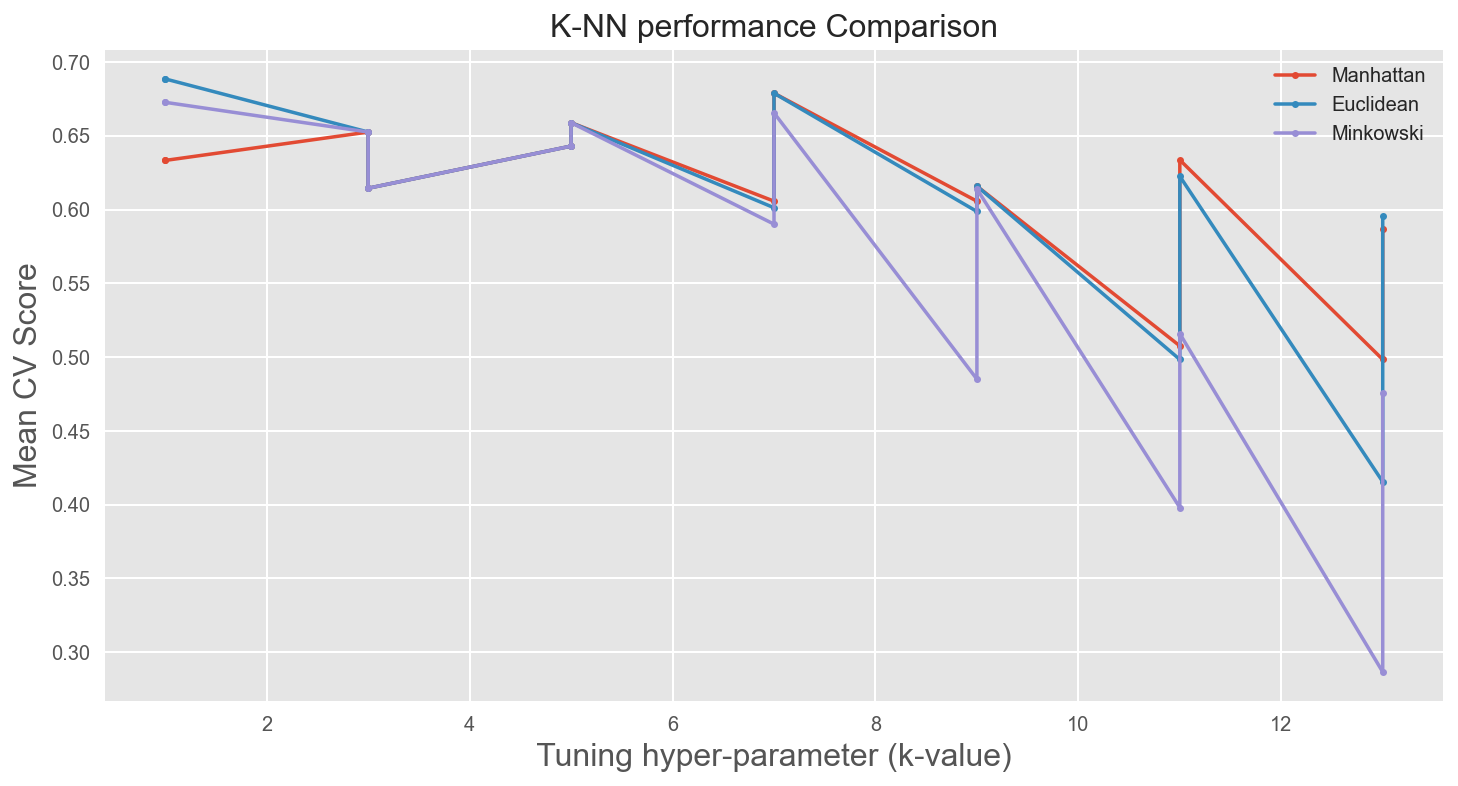

In [219]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['knn__n_neighbors'][:14], temp['f1_score'][:14], marker = '.', label = i)
   
plt.legend()
plt.title("K-NN performance Comparison", fontsize=16)
plt.xlabel(" Tuning hyper-parameter (k-value) ", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)
plt.show()


We observe that the best set of hyperparameters is as follows: Minkowski metric with a k = 3.


## Conclusion - K-NN hyperparameters

(1) Number of neighbors k = 9.

(2) Metric = Manhattan (p = 1)

(3) F1_score = 65% and std: 45%

Let's test the perfomance of other algorithms.

# 2. Using other algorithms: SVM? or Logistic Regression?, Neural Network, and randomForest

In this second part, we train three ML classifiers: Support Vector Machine (SVM) ?? / logistic regression ??, Neural Network (NN), and RandomForest using GridSearch.


## 2.1 Shall we use SVM or Logistic Regression?

Assumption: Given that the number of features, n == 30, is less than the number of training samples (between 10 000 and 20 000 depending on the training size we will chose), the SVM with Gaussian Kernel is more likely to perform better than the logistic regression. In any case, the output of GridSearch will confirm it or no.  

## 2.2 Hyperparameter tuning of SVM, NN, and randomForest

We wrote the scripts below to set all the parameters of each classifier and to run them once using GridSearch.

In [191]:
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

model_params = {
    'svm': {
        'model': svm.SVC(),
        'params': {
             'C': [1, 100, 1000],
             'gamma': [0, 0.1, 0.01,0.001, 0.0001, 0.00001, 20],
             'kernel': ['linear', 'rbf', 'sigmoid', 'poly']    
        }
    },
    'neural_network': {
        'model': MLPClassifier(),
        'params': {
            'hidden_layer_sizes': [[5], [10, 5],[10, 5, 5], [10, 20, 20]],
            'activation': ['logistic', 'relu', 'tanh'],
            'solver': ['lbfgs','sgd','adam'],
            'max_iter': [50, 100, 200, 300, 1000]
            }
    },
    'random_forest': {
        'model': RandomForestClassifier(n_jobs=7),
        'params':{
            'criterion': ['gini','entropy'],
            'max_depth': list(range(1, 20)),
            'max_features': [10, 20, X.shape[1]],
            'n_estimators': list(range(1, 20))
        }
    }  
}

In [216]:
scores = []

cv_method = RepeatedStratifiedKFold(n_splits = 5,
                                   n_repeats = 1,
                                   random_state = 1)

for model_name, classifier in model_params.items():
    gs_ML = GridSearchCV(estimator = classifier['model'], 
                         param_grid = classifier['params'], 
                         cv = cv_method,
                         scoring = 'f1',
                         n_jobs = num_cpus -1,
                         verbose = 3)    
    gs_ML.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': gs_ML.best_score_,
        'best_params': gs_ML.best_params_,
        'cv_results': gs_ML.cv_results_
    })


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 420 out of 420 | elapsed:   26.7s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=7)]: Done  22 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done 134 tasks      | elapsed:   27.4s
[Parallel(n_jobs=7)]: Done 294 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 518 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 806 tasks      | elapsed:  3.4min
[Parallel(n_jobs=7)]: Done 900 out of 900 | elapsed:  3.9min finished
C:\Users\adjanni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 5 folds for each of 2166 candidates, totalling 10830 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:    4.4s
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:   12.5s
[Parallel(n_jobs=7)]: Done 498 tasks      | elapsed:   23.7s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   42.4s
[Parallel(n_jobs=7)]: Done 1138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 1554 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 2034 tasks      | elapsed:  2.3min
[Parallel(n_jobs=7)]: Done 2578 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done 3858 tasks      | elapsed:  4.5min
[Parallel(n_jobs=7)]: Done 4594 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done 5394 tasks      | elapsed:  6.5min
[Parallel(n_jobs=7)]: Done 6258 tasks      | elapsed:  7.5min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed:  8.8min


Fitting 5 folds for each of 114 candidates, totalling 570 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  12 out of  18 | elapsed:    0.1s remaining:    0.0s


ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

In [ ]:
model_best_KNN.pkl

## The optimal parameters are...

It is clear that the F1-score of NN (approx 83%) outperformed KNN (approx. 78%), SVM (approx. 75%), randomForest (approx. 63%), and decisionTree (approx. 68%) classifiers.

### Can we imporove the performance of the Neural Network model? Why is the SVM, KNN, and randomForest are performing so poorly? I was expected the performance of the DecisionTree to be less than the randomForest one.

In [220]:
# Append KNN parameters
scores.append({
    'model': 'K-NN',
    'best_score': gs_pipe_KNN.best_score_,
    'best_params': gs_pipe_KNN.best_params_
}) 

df = pd.DataFrame(scores,columns = ['model', 'best_score', 'best_params'])

df = df.sort_values(by = 'best_score', ascending=False)
df

,model,best_score,best_params
1,neural_network,0.833312,"{'activation': 'tanh', 'hidden_layer_sizes': [..."
2,random_forest,0.699862,"{'criterion': 'gini', 'max_depth': 18, 'max_fe..."
3,K-NN,0.689535,"{'fselector__k': 20, 'fselector__score_func': ..."
4,K-NN,0.689535,"{'fselector__k': 20, 'fselector__score_func': ..."
0,svm,0.666625,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"


### Predicting test set using the top 2 models



In [ ]:
## Neural Network
classifier_NN = MLPClassifier(activation = 'tanh', hidden_layer_sizes = [10, 20, 20], max_iter = 300, solver = 'lbfgs')
y_pred
## Random Forest
classifier_RF = RandomForestClassifier(criterion = 'gini' max_depth = 18, max_features = 30, n_estimators = 15)


## Define models given hyperparameters



In [226]:
import joblib
model_KNN = joblib.load('model_best_KNN.pkl')


In [207]:
estimator_KNN = model_KNN
estimator_NN = MLPClassifier(activation = 'tanh', hidden_layer_sizes = [5], max_iter = 100, solver = 'adam')
estimator_SVM = svm.SVC(C = 1000, gamma = 0.001, kernel = 'rbf')
estimator_RF = RandomForestClassifier(max_depth = 9, max_features = 30, n_estimators = 110)
estimator_DT = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, min_samples_split = 3)

estimators = [(estimator_KNN, 2), (estimator_NN, 2), (estimator_SVM, 2), (estimator_RF, 2)]

In [208]:
X_train.shape

(7973, 30)

# ============== DO NOT CHECK FURTHER  ======================

## ====================== (work in progress) ================================







# Check for bias or variance in our classifier

Shall we increase the number of training set or the number of features to improve the f1_score of our classifiers ??

To answer this question, we plot the learning curve



## Learning curves of the all the classifiers...

In [222]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Learning curve
## Deciding upon the training set sizes
# The minimum is 1. The max is given by the number of elements in the training set! The training set has 9967 elements, hence the
#max is 9967. However, we should set aside the validation set. We perform this with a ratio 80:20. This lead to the following:
# (1) Training set: 7974
# (2) Validation set: 1993
##cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)



#### 1. Artificialy reduce the size of my training set

In [ ]:
##### 1. Artificialy reduce the size of my training set

train_sizes = np.linspace(0.0001, 1, 100)



train_sizes, train_scores, validation_scores = learning_curve(estimator = estimator_NN,
                                                             X = X_train,
                                                             y = y_train,
                                                             train_sizes = train_sizes, 
                                                             cv = kfold,
                                                             n_jobs = 7,
                                                             scoring = "f1_weighted",
                                                             verbose = 5)
print("Training length",X_train.shape)
print("Training score:\n\n", train_scores)
print("\n", '-' *70)
print("Validation score:\n\n", validation_scores)

In [197]:
kfold = StratifiedKFold(n_splits=8, shuffle = True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X_train, y_train):
    # select rows
    train_X, test_X = X_train[train_ix], X_train[test_ix]
    train_y, test_y = y_train[train_ix], y_train[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print(">>>>>> y train unique", set(train_y), "y test unique", set(test_y))
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    

>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8708, 1=12, Test: 0=1245, 1=2
>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8709, 1=12, Test: 0=1244, 1=2
>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8709, 1=12, Test: 0=1244, 1=2
>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8709, 1=12, Test: 0=1244, 1=2
>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8709, 1=12, Test: 0=1244, 1=2
>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8709, 1=12, Test: 0=1244, 1=2
>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8709, 1=13, Test: 0=1244, 1=1
>>>>>> y train unique {0, 1} y test unique {0, 1}
>Train: 0=8709, 1=13, Test: 0=1244, 1=1


In [198]:
# To plot the learning curve, we only need a single error score per training set size, not 5.
train_scores_mean = train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)


print("Mean Training Score  \n\n", pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean Training Score  

 1       1.000000
88      1.000000
177     1.000000
265     1.000000
353     1.000000
441     1.000000
529     1.000000
617     1.000000
705     1.000000
793     0.990645
881     0.994192
969     0.991079
1057    0.996142
1145    0.998032
1233    0.998174
1321    0.998414
1410    0.998186
1498    0.997347
1586    0.998902
1674    0.998845
1762    0.997303
1850    0.999184
1938    0.998845
2026    0.999265
2114    0.999256
2202    0.998024
2290    0.999387
2378    0.999426
2466    0.999296
2554    0.999462
          ...   
6165    0.999654
6253    0.999635
6342    0.999597
6430    0.999551
6518    0.999627
6606    0.999627
6694    0.999519
6782    0.999469
6870    0.999547
6958    0.999511
7046    0.999503
7134    0.999433
7222    0.999480
7310    0.999557
7398    0.999481
7486    0.999460
7575    0.999433
7663    0.999456
7751    0.999413
7839    0.999422
7927    0.999415
8015    0.999376
8103    0.999414
8191    0.999369
8279    0.999370
8367    0.999394
8455   

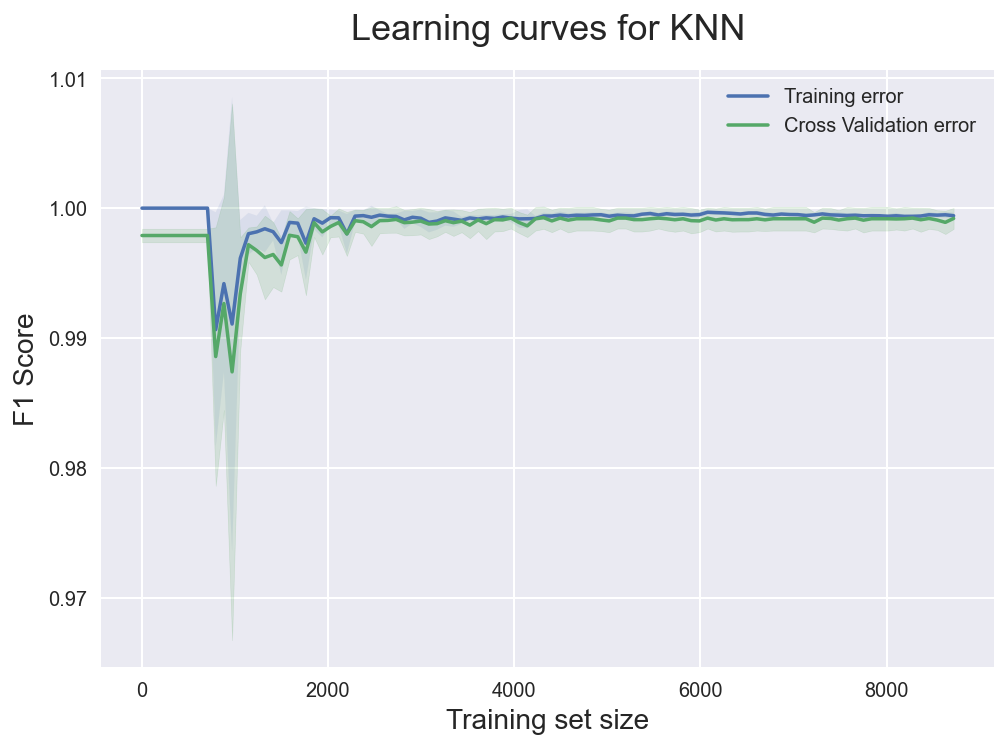

In [199]:
# Leaning curve
plt.style.use("seaborn")
plt.plot(train_sizes, train_scores_mean, label = "Training error")
plt.plot(train_sizes, validation_scores_mean, label = 'Cross Validation error')

plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean-validation_scores_std,validation_scores_mean+validation_scores_std,color = 'green', alpha=0.1 )


plt.ylabel('F1 Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for KNN', fontsize = 18, y = 1.03)
plt.legend()


In [ ]:
X_train.shape

[learning_curve] Training set sizes: [   7  170  333  495  658  820  983 1145 1308 1470 1633 1796 1958 2121
 2283 2446 2608 2771 2933 3096 3259 3421 3584 3746 3909 4071 4234 4396
 4559 4721 4884 5047 5209 5372 5534 5697 5859 6022 6184 6347 6510 6672
 6835 6997 7160 7322 7485 7647 7810 7973]


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 147 out of 750 | elapsed:    1.1s remaining:    4.8s
[Parallel(n_jobs=-2)]: Done 298 out of 750 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-2)]: Done 449 out of 750 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done 600 out of 750 | elapsed:    1.1s remaining:    0.2s


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 7, n_neighbors = 9

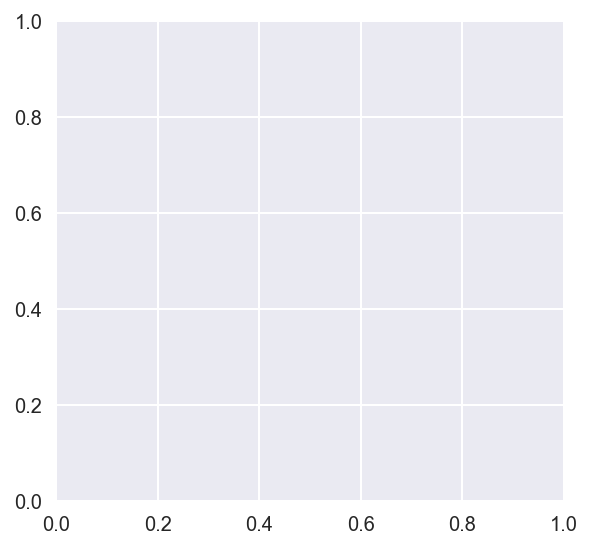

In [202]:
def learning_curves(estimator, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, features, target, 
    train_sizes = train_sizes,
    cv = cv,
    n_jobs = -2,
    scoring = 'f1_weighted',
    verbose = 5)

    train_scores_mean = train_scores.mean(axis = 1)
    train_scores_std = train_scores.std(axis = 1)
    
    validation_scores_mean = validation_scores.mean(axis = 1)
    validation_scores_std = validation_scores.std(axis = 1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Cross Validation error')
    
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, validation_scores_mean-validation_scores_std,validation_scores_mean+validation_scores_std,color = 'green', alpha=0.1 )

    plt.ylabel('F1 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    
#     
#X_train, y_train = load_digits(return_X_y=True)

plt.figure(figsize=(10, 15))

cv_method = RepeatedStratifiedKFold(n_splits = 5,
                                   n_repeats = 3,
                                   random_state = 1)
train_sizes = np.linspace(0.001, 1, 50)

for model, i in estimators:
    plt.subplot(3, 2, i)
    learning_curves(model, X_train, y_train, train_sizes = train_sizes, cv = cv_method)


In [203]:
from sklearn.model_selection import StratifiedKFold

cv_method = StratifiedKFold(n_splits = 5,
                            random_state = 1)


    
    
for train_index, test_index in cv_method.split(X_train, y_train):
    print(X_train.shape)
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("Uniqe", set(y_train[test_index]))
    X_train, X_test = X_train[train_index], X_train[test_index]
    y_train, y_test = y_train[train_index], y_train[test_index]
    
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_train==1])
    print("Train: 0=%d, 1=%d, Test: 0=%d, 1=%d" % (train_0, train_1, test_0, test_1))

(9967, 30)
Uniqe {0, 1}


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1994 but corresponding boolean dimension is 7973

NameError: name 'plot_learning_curve' is not defined

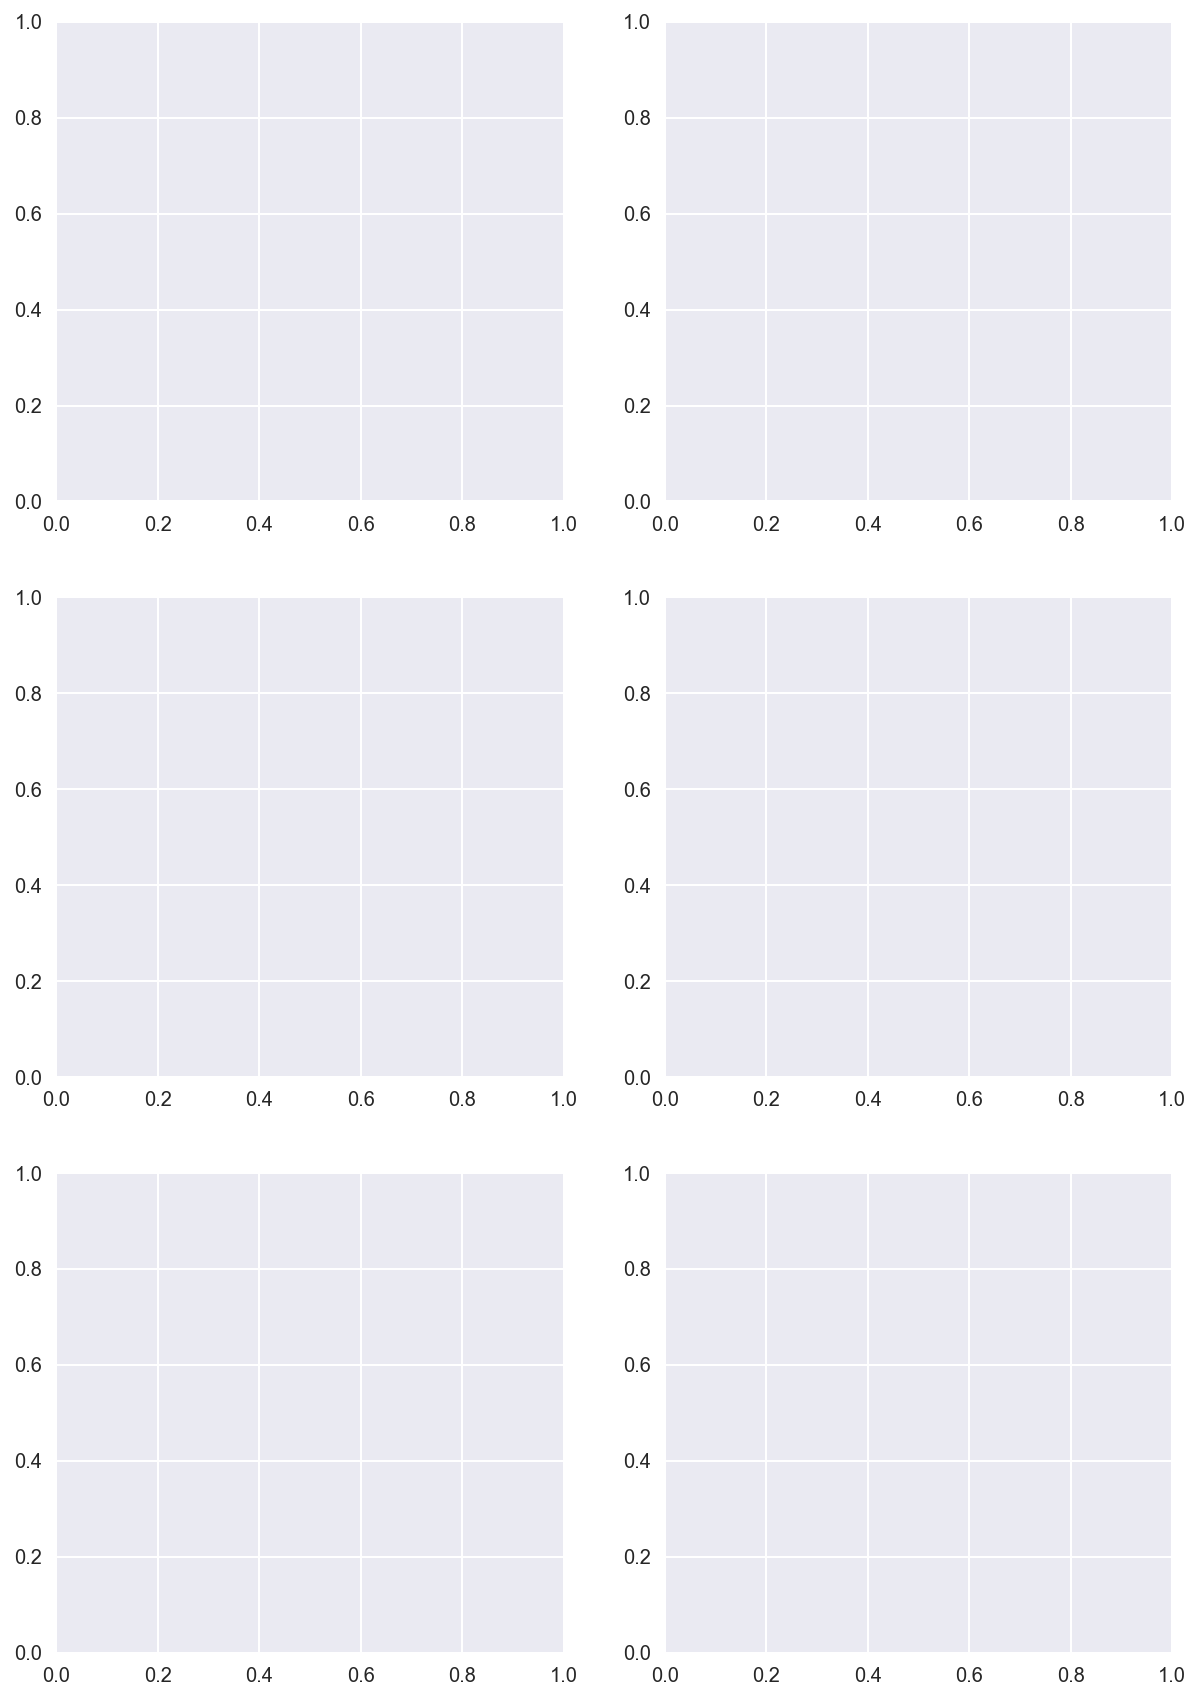

In [204]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
#X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

#cv_method = RepeatedStratifiedKFold(n_splits = 3,
 #                                  n_repeats = 1,
  #                                 random_state = 999)
cv_method = ShuffleSplit(n_splits=100, 
                  test_size=0.2, 
                  random_state=0)

plot_learning_curve(estimator_KNN, title, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01), cv = cv_method, n_jobs = 7)

plot_learning_curve(estimator_NN, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01), cv = cv_method, n_jobs = 7)

plot_learning_curve(estimator_SVM, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01), cv = cv_method, n_jobs = 7)

plot_learning_curve(estimator_RF, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01), cv = cv_method, n_jobs = 7)


In [215]:
from sklearn.model_selection import cross_val_score


cv_method_comp = RepeatedStratifiedKFold(n_splits = 5,
                                   n_repeats = 3,
                                   random_state = 1)

# Best estimators parameters from hyperparameter tuning
cv_results_NN = cross_val_score(estimator = estimator_NN,
                                 X = X_train,
                                 y = y_train, 
                                 cv = cv_method_comp, 
                                 n_jobs = 7,
                                 scoring='f1',
                                 verbose = 4)
cv_results_NN.mean().round(3)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   6 out of  15 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=7)]: Done  10 out of  15 | elapsed:    2.9s remaining:    1.4s
[Parallel(n_jobs=7)]: Done  15 out of  15 | elapsed:    3.4s finished


0.68

# Retraining the models

Here, we re-train the models with the whole trainining set (80% of the dataset), not just the 5% we used to determine the hyperparameters, and make prediction on a new dataset (20% test set).

In [ ]:
#  Features
X = credit_card_d;

# Choose 100% of the data for hyperparameters turming
fracs = 1

# Taking 100% of the datasets for testing purposes
X = credit_card_d.sample(frac = fracs, random_state = 1)

# Target (expected class)
y = credit_card["Class"];
y = credit_card["Class"].sample(frac = fracs, random_state = 1)

# Extract the numpy array for processing purposes
X_data = X.values;
y_data = y.values;

###############################
train_ratio = 0.8
#validation_ratio = 0.2
test_ratio = 0.2
###############################

# To keep the same result with every run
np.random.seed(0)

# split 70% and 30%
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=1 - train_ratio);

# Compute the mean and standard deviation on a training set [-1 1]
scaler = preprocessing.StandardScaler().fit(X_train)

# Apply the feature scaling on x_train
X_train = scaler.transform(X_train)

# Reapply the same transformation on the test set
X_test = scaler.transform(X_test)

##  K-NN Model deployment: Loading model  for Prediction

We retrieve the saving model object

In [ ]:
import joblib
model_KNN = joblib.load('model_best_KNN.pkl')

In [ ]:
# Re-training the model
model_KNN.fit(X_train, y_train)

# Making new prediction
y_pred = model_KNN.predict(X_test)

f1_knn = f1_score(y_test, y_pred)

print("f1_score Score of the knn classifier for best k values of "+str(3)+" is: "+str(f1_knn))

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

dataFrame = pd.DataFrame(cm, index = ['Normal', 'Fraudulent'], columns = ['Normal', 'Fraudulent'])
sns.heatmap(dataFrame, annot = True, cbar = None, cmap = "Blues", fmt = 'g', linewidths = 2, linecolor = "black")
plt.title("Confusion Matrix on Test set")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")

print("True Negative", TN, "\n False Positive ",FP, "\n False Negative",FN , "\n True Positive", TP)

classification = metrics.classification_report(y_test, y_pred)   
print("Classification Report:" "\n", classification)  